In [1]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [2]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [3]:
SD = 0.05 * (0.8 ** 7) # -4 ... 10 
print('SD:', SD)

SD: 0.010485760000000004


In [4]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMZN', 'ANET', 'APPH', 'ATVI', 'AXON', 'AYX',
    'BILI', 'BYND', 'COUR','CPNG', 'DDOG', 'DOCU', 'DUOL', 'EDIT', 
    'ELIO', 'ETSY', 'FSLY', 'FUV', 'GH', 'GMED', 'GOOG', 'INTG', 'ISRG', 
    'JD', 'LULU', 'LUV', 'MDB', 'MELI', 'MNST', 'MSFT', 'MTCH', 'NVCR', 
    'OKTA', 'PANW', 'PINS', 'PTON', 'QDEL', 'RDFN', 'RGEN', 'ROKU', 'SE', 
    'SHOP', 'SPLK', 'TDOC', 'TEAM', 'TREX', 'TSLA', 'TTD', 'TTWO', 'TWLO', 
    'TWTR', 'UPST', 'VEEV', 'ZEN', 'ZG', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA']  # NY Stock Exchange (total)
len(SYMBOLS)

55

In [5]:
N_YEARS = 50
N_CUTS = 10
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = '1978-07-26' #str(TODAY - timedelta(N_DAYS))
START, TODAY

('1978-07-26', datetime.date(2021, 9, 14))

In [6]:
batcher = Batcher(SYMBOLS, INDICES)
batch = batcher.get_batch_from_weekday(TODAY.weekday())
batch

['CPNG',
 'DDOG',
 'DOCU',
 'DUOL',
 'EDIT',
 'ELIO',
 'ETSY',
 'FSLY',
 'FUV',
 'GH',
 'GMED',
 '^IXIC']

In [7]:
stock_loader = Loader(batch, START, verbose=True)
data = stock_loader.download()

[*********************100%***********************]  12 of 12 completed
Generating derived columns...
   ...CPNG
   ...DDOG
   ...DOCU
   ...DUOL
   ...EDIT
   ...ELIO
   ...ETSY
   ...FSLY
   ...FUV
   ...GH
   ...GMED
   ...^IXIC


In [8]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [9]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [10]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(f'Unexpected error getting {stock} data. '
              'Initialized as None.')

In [11]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [12]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best.json', 'w') as f:
        json.dump(best_param_set, f)

In [13]:
if TODAY.weekday() == 0:
    !say update standard deviation




----------------------------------------------------------------------
                                 CPNG
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 0.6531590097079472
Refitting current best...
Current best ma returns: 0.8836791086572446
Fraction Invested: 0.521224285057911
Beginning random search...
New best: 0.8576028303201166
Invested: 0.49985639587530317
New best: 0.8679387026328864
Invested: 0.45391537562595763
New best: 0.8477158909827298
Invested: 0.4382488769406522
New best: 0.8385511917786808
Invested: 0.695687479054511
New best: 0.9207959108818944
Invested: 0.14758506613108846
New best: 0.8680552085269164
Invested: 0.6048079793283806
New best: 0.8137609536801556
Invested: 0.6216867886596792
New best: 0.8405793178501233
Invested: 0.4187044858568535
New best: 0.849872085294169
Invested: 0.530395807304369
New best: 0.8182518380743

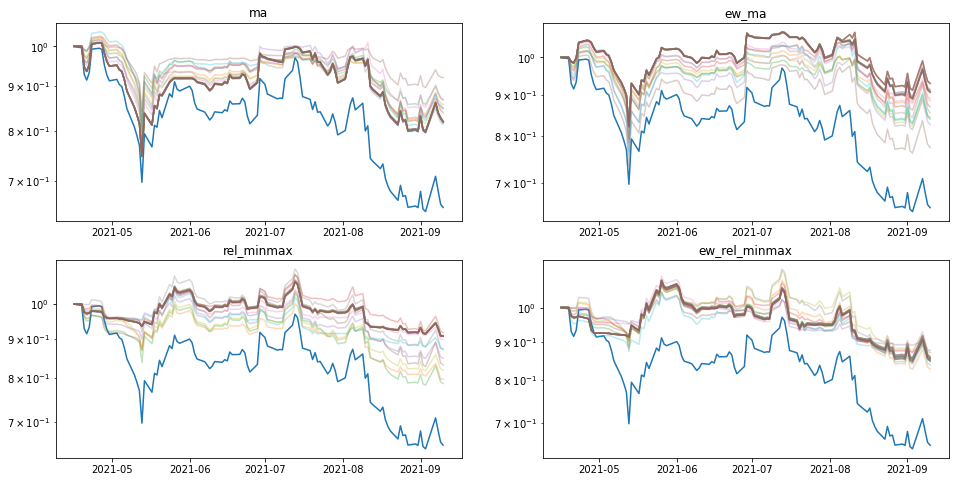

Saving CPNG params...



----------------------------------------------------------------------
                                 DDOG
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.8686465165655277
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.8686465165655277
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 2.8686465165655277
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning ew_rel_minmax method...
-------------

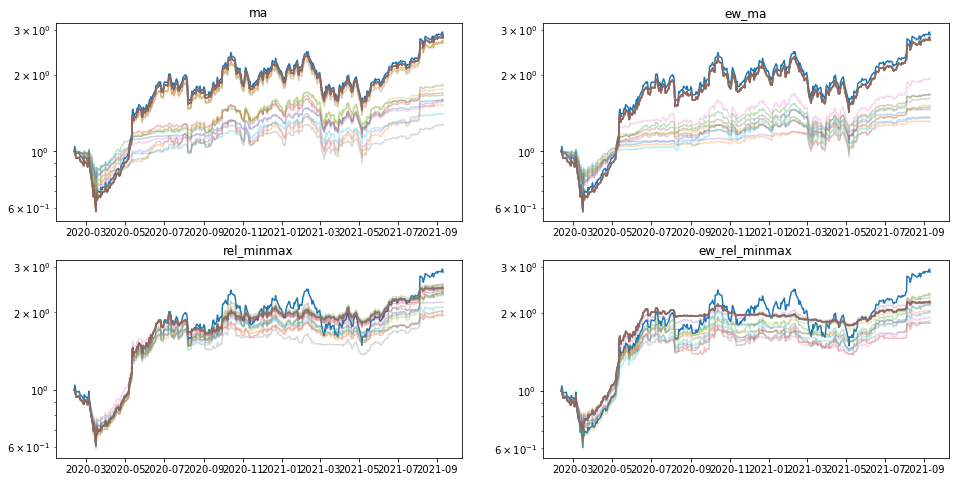

Saving DDOG params...



----------------------------------------------------------------------
                                 DOCU
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 6.914919691489228
Refitting current best...
Current best ma returns: 7.198757859322519
Fraction Invested: 0.9989865599308331
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 7.198651234408135
Invested: 0.9989865599308331
New best: 7.198675486828996
Invested: 0.9989865599308331
New best: 7.198675486828996
Invested: 0.9989865599308331
New best: 7.1979949066277
Invested: 0.9989865599308331
New best: 7.1979272631437174
Invested: 0.9989865599308331
New best: 7.905936878047555
Invested: 0.9989865599308331
New best: 7.197800579345844
Invested: 0.9989865599308331
New best: 7.197922771657914
Invested: 0.9989865599308331
New best: 7.197990198081314
Inve

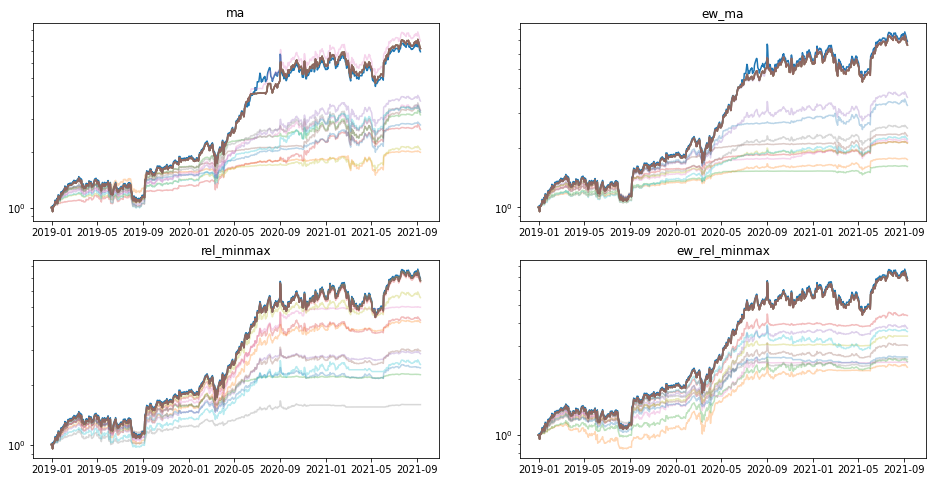

Saving DOCU params...



----------------------------------------------------------------------
                                 DUOL
----------------------------------------------------------------------
No saved data. Initialized as None


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.1874657199807364
Refitting current best...
Current best ma returns: 1.2885435660414237
Fraction Invested: 0.9920279440699441
Beginning random search...
New best: 1.2196831813081266
Invested: 0.6915832788239288
Round: 10
Beginning adjusted search...
New best: 1.2196831813081266
Invested: 0.6915832788239288
New best: 1.2196831813081266
Invested: 0.6915832788239288
New best: 1.2196831813081266
Invested: 0.6915832788239288
New best: 1.2196831813081266
Invested: 0.6915832788239288
New best: 1.2196831813081266
Invested: 0.6915832788239288
New best: 1.2194979536121813
Invested: 0.6915832788239288
New best: 1.219519270210991
Invested: 0.6915832788239288
New best

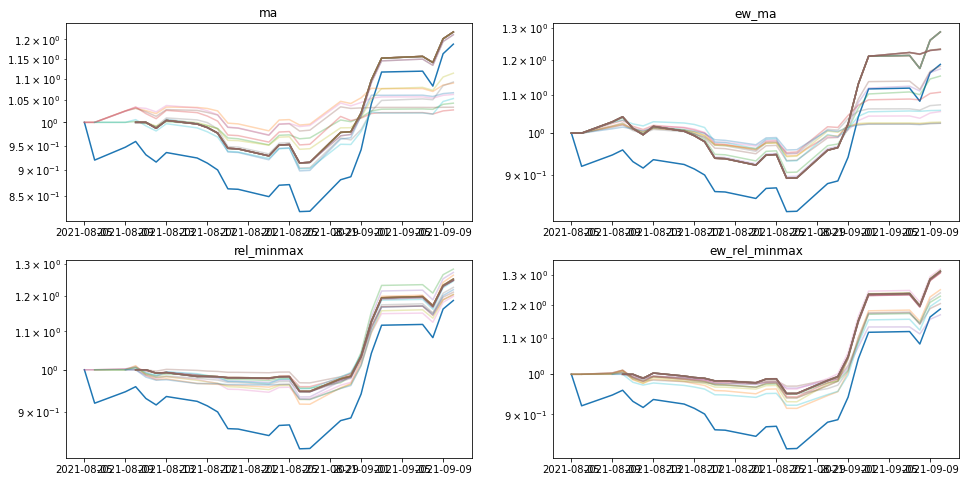

Saving DUOL params...



----------------------------------------------------------------------
                                 EDIT
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.9641255935232937
Refitting current best...
Fraction Invested: 1
Beginning random search...
New best: 3.0676076457634114
Invested: 0.3362103322319163
Round: 10
Beginning adjusted search...
New best: 3.0723198608992925
Invested: 0.3362103322319163
New best: 3.0717735264591424
Invested: 0.3362103322319163
New best: 3.0715983640415954
Invested: 0.3362103322319163
New best: 3.0715983640415954
Invested: 0.3362103322319163
New best: 3.0671567241365976
Invested: 0.3362103322319163
New best: 3.074982881683389
Invested: 0.3362103322319163
New best: 3.0716943168755444
Invested: 0.34279977369530057
New best: 3.065013433272766
Invested: 0.34279977369530057
New best: 3.068939442403

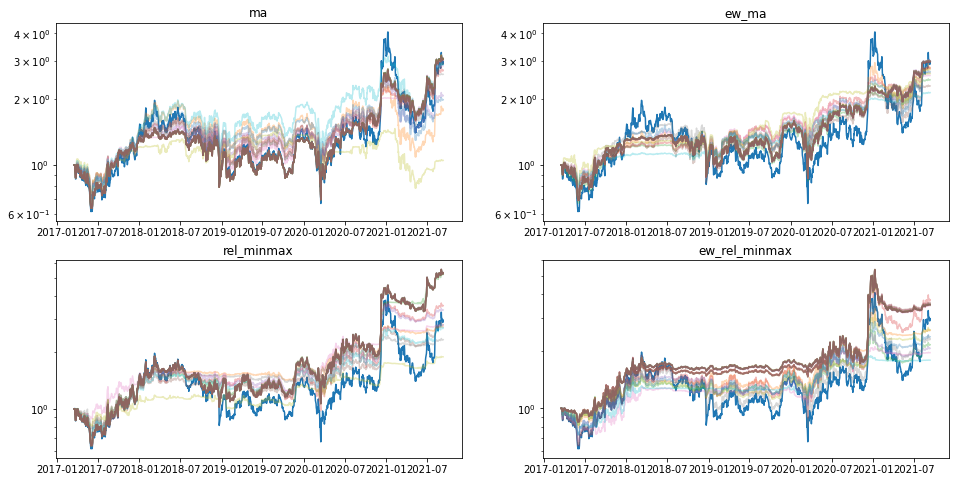

Saving EDIT params...



----------------------------------------------------------------------
                                 ELIO
----------------------------------------------------------------------
No saved data. Initialized as None


Beginning ma method...
--------------------------------------------------
Do nothing returns: 0.27833332618077594
Refitting current best...
Fraction Invested: 1
Beginning random search...
New best: 1.2905879002170662
Invested: 0.020537740198848353
New best: 0.3275101832039983
Invested: 0.4935912968121403
New best: 1.7645183558710686
Invested: 0.0018229501504873902
New best: 2.056207871823131
Invested: 0.05439403198314896
New best: 0.4212033197619444
Invested: 0.3340886449543484
New best: 0.5964766437824188
Invested: 0.16107199456016752
New best: 2.5523101704224676
Invested: 0.16653212644164073
New best: 1.3347135766626528
Invested: 0.16477928778189055
New best: 1.9568648436729414
Invested: 0.026615058939632674

Beginning adjusted search...
New best

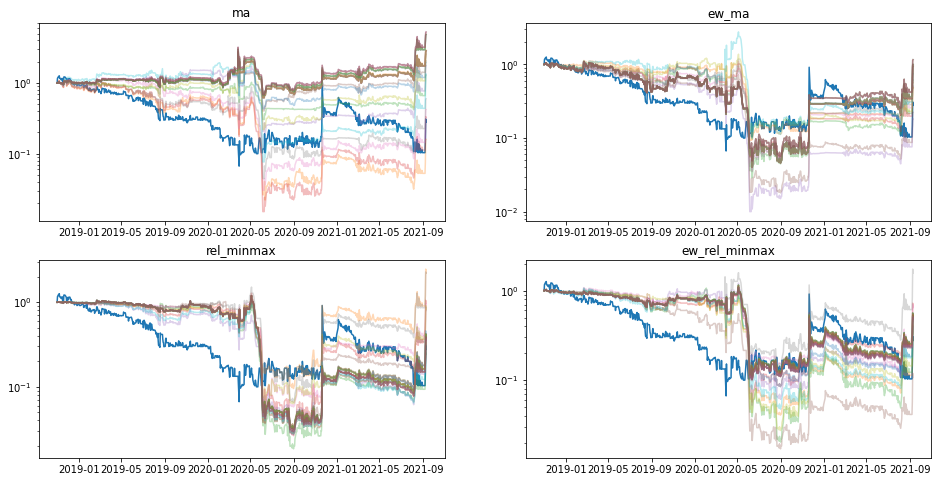

Saving ELIO params...



----------------------------------------------------------------------
                                 ETSY
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 22.01014318752981
Refitting current best...
Current best ma returns: 22.177491713642173
Fraction Invested: 0.9999517968251496
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 22.177210756244666
Invested: 0.9999517968251496
New best: 22.146311502737667
Invested: 0.9999517968251496
New best: 22.122706586635832
Invested: 0.9999517968251496
New best: 22.140423607330437
Invested: 0.9999517968251496
New best: 22.140264100370185
Invested: 0.9999517968251496
New best: 22.140264122276527
Invested: 0.9999517968251496
New best: 22.140018952068427
Invested: 0.9999517968251496
New best: 22.131776480762074
Invested: 0.9999517968251496
New best: 22.147755793

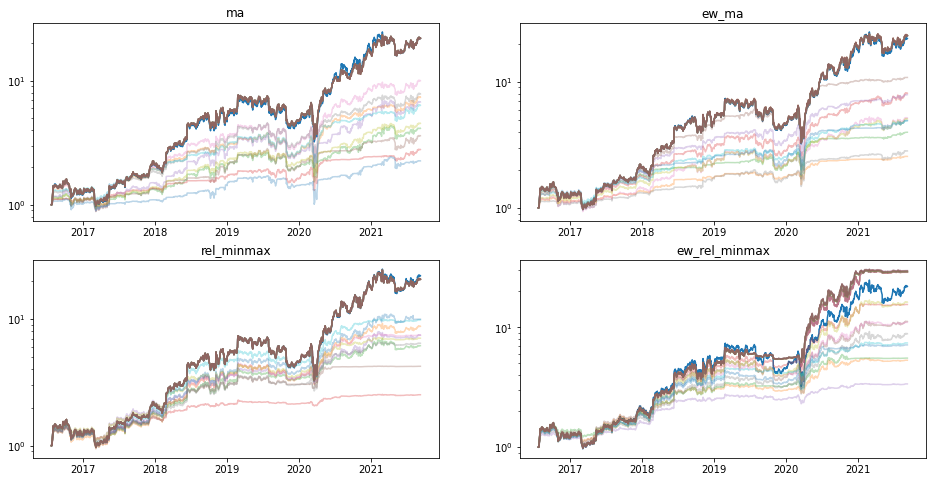

Saving ETSY params...



----------------------------------------------------------------------
                                 FSLY
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.1205400206166547
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 108
Beginning adjusted search...
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.1205400206166547
Refitting current best...
Current best ew_ma returns: 2.1517823855236093
Fraction Invested: 0.999028470791946
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 2.151847502116465
Invested: 0.999028470791946
New best: 2.146567397187594
Invested: 0.999028470791946
New best: 2.1346334154653266
Invested: 0.999028470791946
New best: 2.1346334154653266
Invested: 0.999028470791946
New best: 2.134

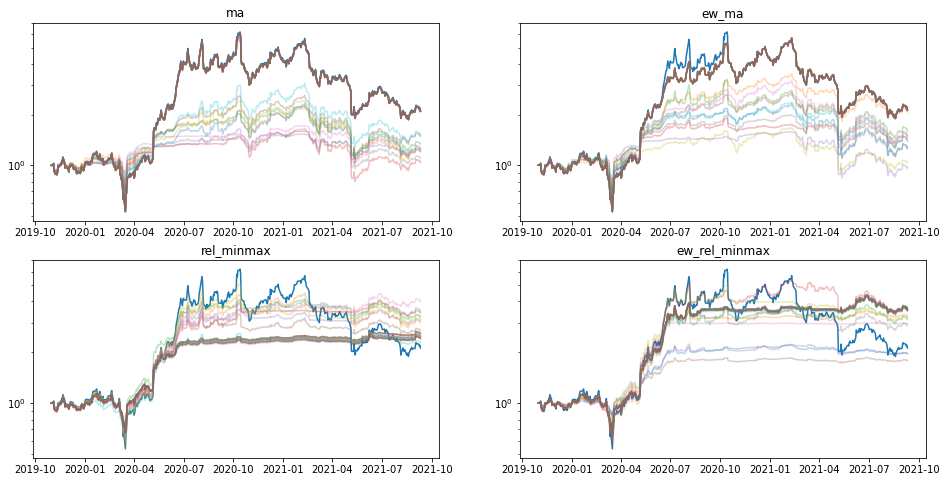

Saving FSLY params...



----------------------------------------------------------------------
                                 FUV
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.8626505642017555
Refitting current best...
Current best ma returns: 2.921620320221492
Fraction Invested: 0.9957060874247814
Beginning random search...
New best: 3.537730132485967
Invested: 0.8451164104214276
Round: 10
Beginning adjusted search...
New best: 3.5485316800578146
Invested: 0.8451164104214276
New best: 3.562445028891606
Invested: 0.8451164104214276
New best: 3.5575674555194214
Invested: 0.8451164104214276
New best: 3.5614524565820043
Invested: 0.8451164104214276
New best: 3.69175357060795
Invested: 0.8451164104214276
New best: 3.680968042855419
Invested: 0.8451164104214276
New best: 3.6775643009638257
Invested: 0.8451164104214276
New best: 3.6657909921830507

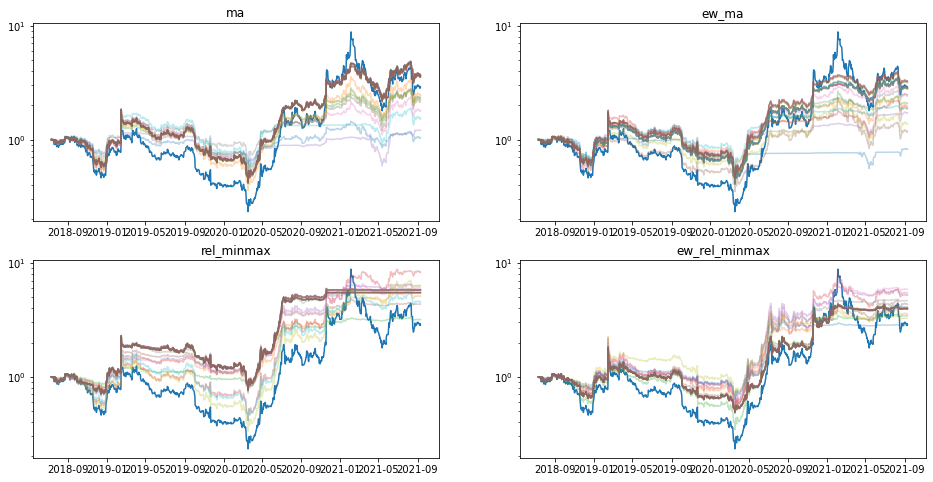

Saving FUV params...



----------------------------------------------------------------------
                                 GH
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.9939759128434156
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.9939759128434156
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 1.9939759128434156
Refitting current best...
Current best rel_minmax returns: 2.0899591202373085
Fraction Invested: 0.7857476140434668
Beginning random search...
New best: 2.3704331568191046
Inv

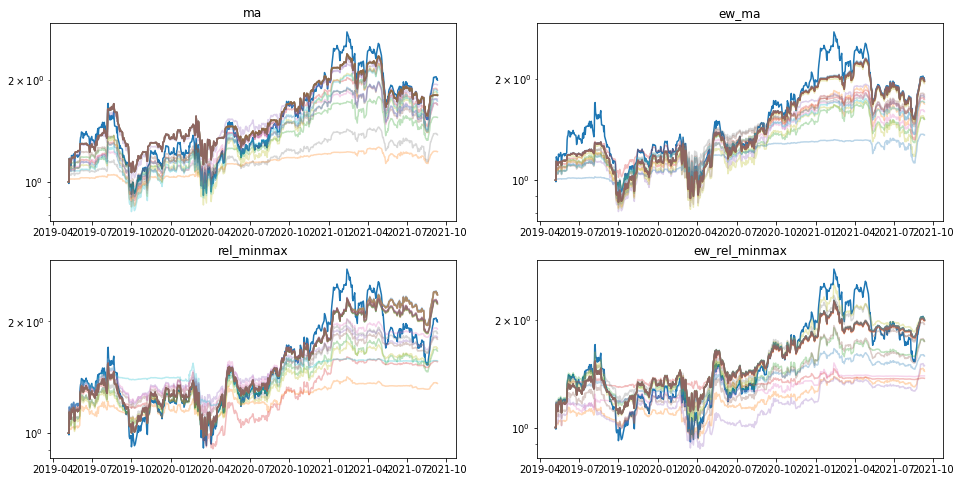

Saving GH params...



----------------------------------------------------------------------
                                 GMED
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.4748291421707855
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 3.4748291421707855
Refitting current best...
Current best ew_ma returns: 3.6316660016039917
Fraction Invested: 0.9920279440699441
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 3.6319419684274266
Invested: 0.9920279440699441
New best: 3.6319266503943837
Invested: 0.9920279440699441
New best: 3.631812386554831
Invested: 0.9920279440699441
New best: 3.6317656370693783
Invested: 0.9920279440699441
New best: 3.

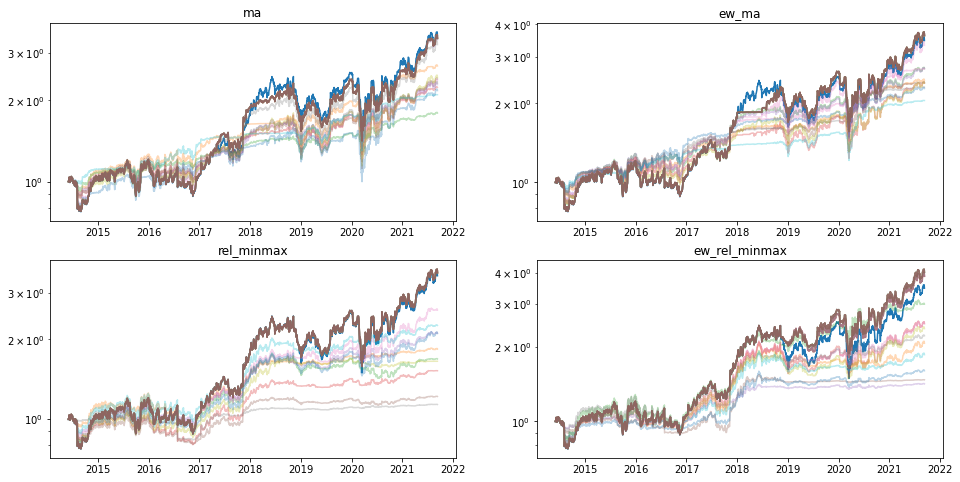

Saving GMED params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 36.04074977193677
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 36.04074977193677
Refitting current best...
Current best ew_ma returns: 37.344986495460724
Fraction Invested: 0.9615934827836614
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 37.344674386389464
Invested: 0.9615934827836614
New best: 37.34475784912523
Invested: 0.9615934827836614
New best: 38.04385036926681
Invested: 0.9615934827836614
New best: 38.04385036926681
Invested: 0.9615934827836614
New best: 38.

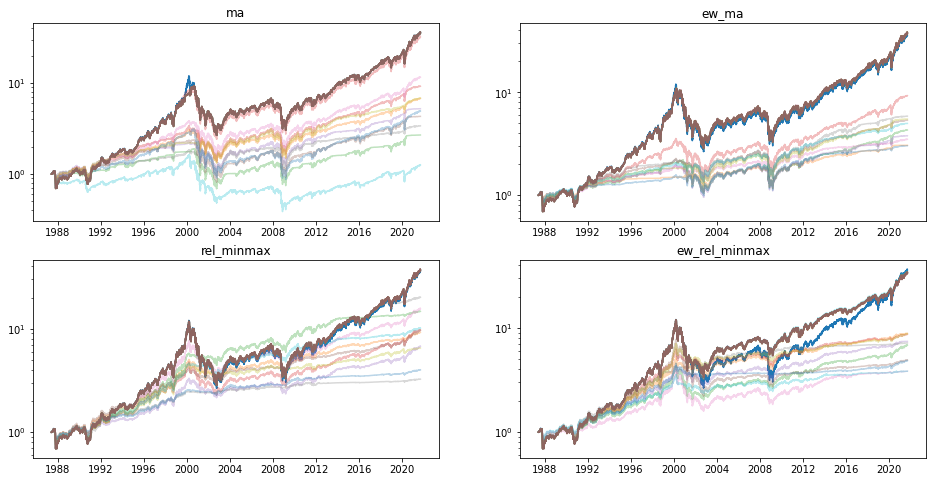

Saving ^IXIC params...


In [14]:
N_RAND = 10
N_ADJ = 15

for stock in batch:
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(stock_data, 
                      N_CUTS, 
                      best_param_set=best_params, 
                      best_returns=best_returns, 
                      sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [15]:
def get_summary(stocks):
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {100 * best_pct:.2f}% in')
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue

In [16]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
get_summary(batch)


CPNG:
  Best Return: 0.9074761848850459 (rel_minmax)
  38.02% in

DDOG:
  Best Return: 2.8686465165655277 (ma)
  100.00% in

DOCU:
  Best Return: 7.196638768919129 (ma)
  99.84% in

DUOL:
  Best Return: 1.311789695334016 (ew_rel_minmax)
  98.61% in

EDIT:
  Best Return: 5.274042666993781 (rel_minmax)
  38.34% in

ELIO:
  Best Return: 5.270647731422212 (ma)
  2.66% in

ETSY:
  Best Return: 29.750640148853762 (ew_rel_minmax)
  2.06% in

FSLY:
  Best Return: 3.5393387819204385 (ew_rel_minmax)
  63.11% in

FUV:
  Best Return: 5.49846855656129 (rel_minmax)
  2.64% in

GH:
  Best Return: 2.2444784366993247 (rel_minmax)
  78.67% in

GMED:
  Best Return: 4.028371623913393 (ew_rel_minmax)
  96.54% in

^IXIC:
  Best Return: 37.63246959519875 (ew_ma)
  96.16% in


In [17]:
!say qp is dunzo

IXIC: Nasdaq